## Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### For Logistic Regression

In [155]:
# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### For XGBoost

In [157]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import optuna

## Data Understanding & Preparation

In [2]:
df.info()
print("\nDataset shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [3]:
# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurre

In [4]:
# Check unique values per column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLas

In [5]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [6]:
# Separate categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_cols)
print("\nNumerical columns:", num_cols)

Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Numerical columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [160]:
numeric_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()

for col in ['Attrition','Attrition_Yes']:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)

print("Numeric features:", len(numeric_features))
print(numeric_features[:10])
print("Categorical features:", len(categorical_features))
print(categorical_features[:10])

Numeric features: 26
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel']
Categorical features: 8
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


## Attrition

In [7]:
# Check target variable distribution
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

## Feature Engineering 

In [ ]:
#Missing Value processing 
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())



cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# Test the Missing values
df.isnull().sum().sum()

np.int64(0)

## Encoding

In [9]:
# categorical ----> binary by  One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True) # drop_first=True to avoid dummy variable 

# Verify the new data
df_encoded.shape

(1470, 48)

In [10]:
# checking.....
print("Total missing values:", df_encoded.isnull().sum().sum())

df_encoded.dtypes.value_counts()

Total missing values: 0


int64    26
bool     22
Name: count, dtype: int64

## Model Training 

In [119]:
#define X as Features and Y as target
X = df_encoded.drop(['Attrition_Yes'], axis=1)
y = df_encoded['Attrition_Yes']

# Data will be 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42, stratify=y
)

# Training and Test shapes 
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1176, 47)
Test set shape: (294, 47)


## Logistic Regression

In [124]:
# Create the Model and Train it
log_model = LogisticRegression(max_iter=1000, random_state=42)
# Fix duplicated columns in y_train
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

log_model.fit(X_train, y_train)

# Prediction
y_pred = log_model.predict(X_test)

Accuracy: 0.8503
Precision: 0.7143
Recall: 0.1064
F1-score: 0.1852


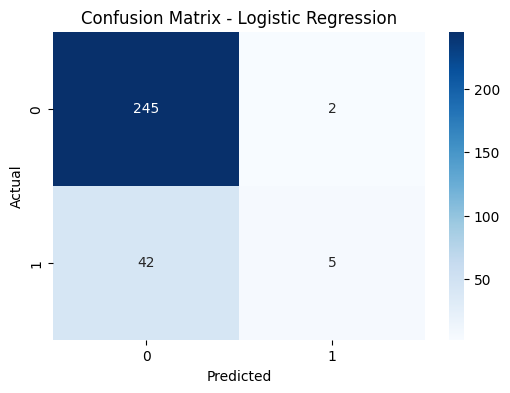


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       247
           1       0.71      0.11      0.19        47

    accuracy                           0.85       294
   macro avg       0.78      0.55      0.55       294
weighted avg       0.83      0.85      0.80       294



In [129]:
# Determining (Accuracy-Precision-Recall-F1) 
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the Results 
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")     
print(f"F1-score: {f1:.4f}")   #Avrage between Acuuracy and Recall 

# Confusion Matrix To clarify Model Preformance 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Print the final report 
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


### The model suffers from imbalance as recall only 0.106 and F1 0.19 which is very low 
### we are going to test if the model have OVERfitting or UNDERfitting 
### if Train Accuracy > Test Accuracy then the model have OVERfitting 

In [130]:
y_train_pred = log_model.predict(X_train)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.8554421768707483
Test Accuracy: 0.8503401360544217


### Balancing

In [134]:
# scale numeric features if needed (we assume all features numeric after get_dummies)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with class_weight balanced
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print("Logistic (class_weight) performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))


Logistic (class_weight) performance:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       247
           1       0.33      0.62      0.43        47

    accuracy                           0.74       294
   macro avg       0.62      0.69      0.63       294
weighted avg       0.82      0.74      0.77       294

ROC AUC: 0.7954173486088381


### Smote

Logistic + SMOTE CV F1 scores: [0.531 0.475 0.496 0.495 0.509]
Mean F1: 0.501

Test set classification report (Logistic+SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       247
           1       0.37      0.62      0.46        47

    accuracy                           0.77       294
   macro avg       0.64      0.71      0.66       294
weighted avg       0.83      0.77      0.79       294

ROC AUC: 0.7811180980273925


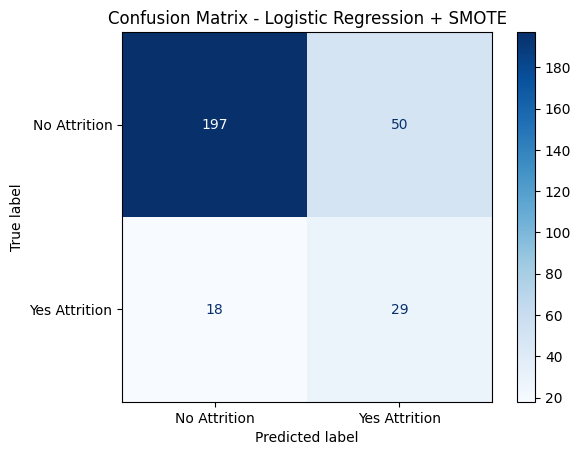

In [136]:
# pipeline: scaler -> SMOTE -> classifier
smote = SMOTE(random_state=42)
pipe_lr_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# quick CV to estimate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_lr_smote, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print("Logistic + SMOTE CV F1 scores:", np.round(scores,3))
print("Mean F1:", np.round(scores.mean(),3))

# fit & evaluate on test
pipe_lr_smote.fit(X_train, y_train)
y_pred = pipe_lr_smote.predict(X_test)
print("\nTest set classification report (Logistic+SMOTE):")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, pipe_lr_smote.predict_proba(X_test)[:,1]))


# Show the new results
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = pipe_lr_smote.predict(X_test)

ConfusionMatrixDisplay.from_estimator(
    pipe_lr_smote, X_test, y_test,
    display_labels=["No Attrition", "Yes Attrition"],
    cmap="Blues",
    values_format='d'
)
plt.title("Confusion Matrix - Logistic Regression + SMOTE")
plt.show()


### we enhanced the model performance in recall and avrage F1 but Accueacy decreased 
### So we are going to try another model

## Random Forest 

### SMOTE

In [137]:
pipe_rf_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
   
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Train The model
pipe_rf_smote.fit(X_train, y_train)

# prediction
y_pred_rf = pipe_rf_smote.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("=== Random Forest + SMOTE ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
try:
    print("ROC AUC:", roc_auc_score(y_test, pipe_rf_smote.predict_proba(X_test)[:,1]))
except:
    pass

=== Random Forest + SMOTE ===
[[227  20]
 [ 36  11]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       247
           1       0.35      0.23      0.28        47

    accuracy                           0.81       294
   macro avg       0.61      0.58      0.59       294
weighted avg       0.78      0.81      0.79       294

ROC AUC: 0.7435610302351624


### Low senstive in recall...

### SMOTE + class_weight='balanced

In [138]:
pipe_rf_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
pipe_rf_smote.fit(X_train, y_train)
y_pred_rf = pipe_rf_smote.predict(X_test)
print("=== RandomForest + SMOTE + balanced ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
try:
    print("ROC AUC:", roc_auc_score(y_test, pipe_rf_smote.predict_proba(X_test)[:,1]))
except:
    pass


=== RandomForest + SMOTE + balanced ===
[[228  19]
 [ 34  13]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       247
           1       0.41      0.28      0.33        47

    accuracy                           0.82       294
   macro avg       0.64      0.60      0.61       294
weighted avg       0.80      0.82      0.81       294

ROC AUC: 0.7442501507451116


### still low Reliability (we cannot rely om this model with employees who will left)

## XG BOOST

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       247
           1       0.62      0.28      0.38        47

    accuracy                           0.86       294
   macro avg       0.75      0.62      0.65       294
weighted avg       0.83      0.86      0.83       294

XGBoost Results:
----------------
Accuracy: 0.8571
Precision: 0.6190
Recall: 0.2766
F1-score: 0.3824


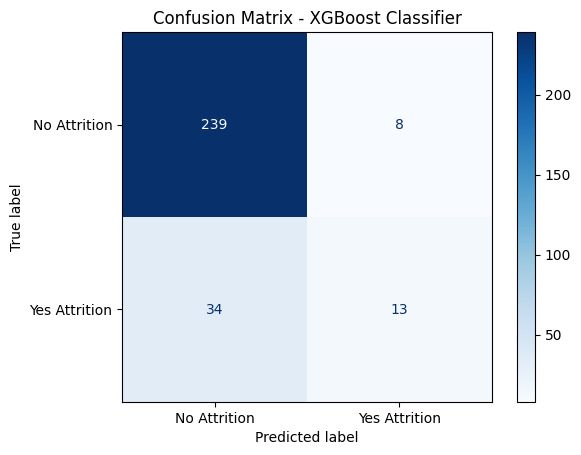

ROC AUC: 0.7774140752864157


In [142]:
# Build the model
xgb_model = XGBClassifier(
    n_estimators=200,       # number of trees
    learning_rate=0.05,     
    max_depth=6,            # tree's depth
    subsample=0.8,          # samples used per tree
    colsample_bytree=0.8,   # columns used per tree
    random_state=42,
    scale_pos_weight=3     
)

# Train the model
xgb_model.fit(X_train, y_train)

# prediction
y_pred_xgb = xgb_model.predict(X_test)

# metrics performance
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Display the Results
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("XGBoost Results:")
print("----------------")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")

ConfusionMatrixDisplay.from_estimator(
    xgb_model, X_test, y_test,
    display_labels=["No Attrition", "Yes Attrition"],
    cmap="Blues",
    values_format='d'
)
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()
print("ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))


### Low recall so we will create GridsearchCV to make balance

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
 Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 5, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       247
           1       0.43      0.55      0.48        47

    accuracy                           0.81       294
   macro avg       0.67      0.71      0.68       294
weighted avg       0.83      0.81      0.82       294


🎯 Best XGBoost Model Performance:
Accuracy: 0.8095
Precision: 0.4262
Recall: 0.5532
F1-score: 0.4815


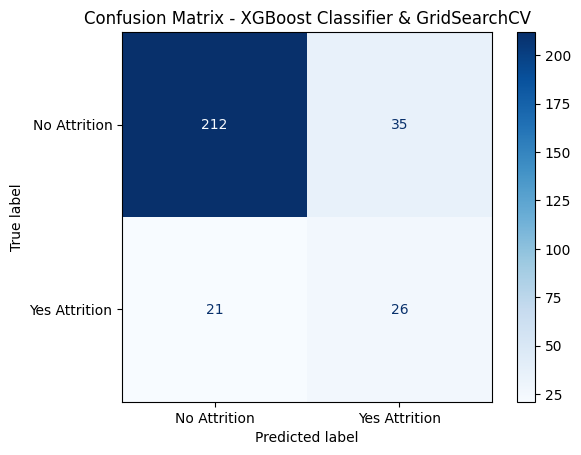

ROC AUC: 0.7768110948402102


In [ ]:
xgb_base = XGBClassifier(random_state=42)

# We will search in.........
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 3, 5]
}

# create GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',        # F1 responsible for balancing between precision and recall
    cv=3,                # 3-fold cross validation
    verbose=2,
    n_jobs=-1            # to icrease search speed
)

# train GridSearchCV
grid_xgb.fit(X_train, y_train)

print(" Best Parameters:", grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_

# prediction
y_pred_best = best_xgb.predict(X_test)

# Performance evaluation
acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
print(classification_report(y_test, y_pred_best, zero_division=0))
print("\n🎯 Best XGBoost Model Performance:")
print(f"Accuracy: {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1-score: {f1_best:.4f}")

ConfusionMatrixDisplay.from_estimator(
    best_xgb, X_test, y_test,
    display_labels=["No Attrition", "Yes Attrition"],
    cmap="Blues",
    values_format='d'
)
plt.title("Confusion Matrix - XGBoost Classifier & GridSearchCV")
plt.show()

print("ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

### The Best Performance till now

## Model Comparation

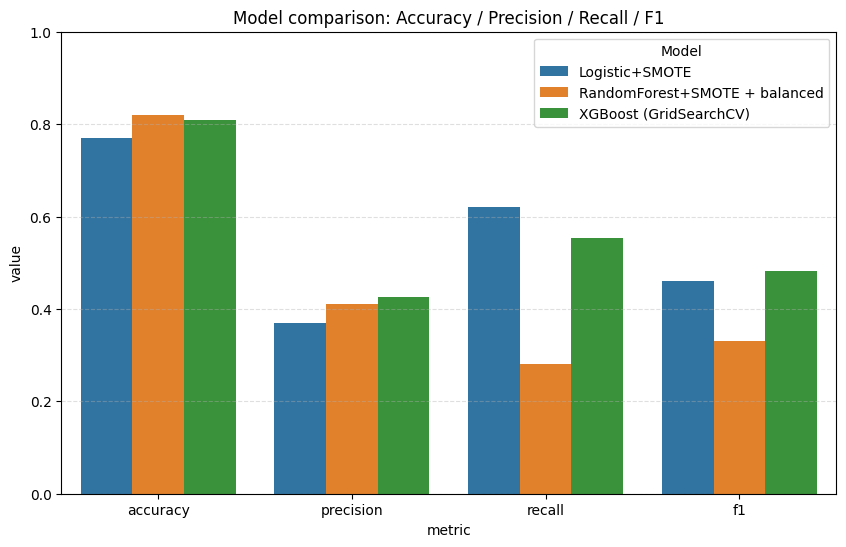

Metrics table:


,accuracy,precision,recall,f1
model,,,,
Logistic+SMOTE,0.7700,0.3700,0.6200,0.4600
RandomForest+SMOTE + balanced,0.8200,0.4100,0.2800,0.3300
XGBoost (GridSearchCV),0.8095,0.4262,0.5532,0.4815


In [141]:
data = {
    'model': ['Logistic+SMOTE', 'RandomForest+SMOTE + balanced', 'XGBoost (GridSearchCV)'],
    'accuracy': [0.77, 0.82, 0.8095],
    'precision': [0.37, 0.41, 0.4262],
    'recall': [0.62, 0.28, 0.5532],
    'f1': [0.46, 0.33, 0.4815]
}

df_metrics = pd.DataFrame(data)

# Melt for seaborn
df_melt = df_metrics.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1'],
                          var_name='metric', value_name='value')

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x='metric', y='value', hue='model')
plt.ylim(0,1)
plt.title("Model comparison: Accuracy / Precision / Recall / F1")
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# Optional: display metrics table
print("Metrics table:")
display(df_metrics.set_index('model'))

# confusion matrices (from predictions)
cm_logistic = [[197, 50], [18, 29]]   
cm_rf = [[228, 19], [34, 13]]         
cm_xgb = [[212, 35], [21, 26]]     

### So best Model performance is (XGBoost (GridSearchCV))

### We will tuning this model for better results

## Tuning The Model selected (XGBoost)

### We will try 2 methods

### 1-RandomizedSearchCV Optimization

In [ ]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
param_dist = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10)
}
random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=40,             
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best F1 Score: {random_search.best_score_:.4f}")

xgb_random_best = random_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
✅ Best parameters found:
{'colsample_bytree': np.float64(0.8732457025590121), 'gamma': np.float64(3.2481644952360735), 'learning_rate': np.float64(0.1798446820988356), 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 787, 'subsample': np.float64(0.5468373839140462)}
Best F1 Score: 0.5089


### The Heighst performance for now

### 2-Bayesian Optimization Using Optuna

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best parameters found by Optuna:")
print(study.best_params)
print(f"Best F1 Score: {study.best_value:.4f}")

best_xgb_optuna = XGBClassifier(**study.best_params)
best_xgb_optuna.fit(X_train, y_train)

[I 2025-10-18 23:50:18,143] A new study created in memory with name: no-name-02199d8a-25b7-4dd5-bf78-0821c390b287


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-18 23:50:19,009] Trial 0 finished with value: 0.4424518085336799 and parameters: {'n_estimators': 203, 'max_depth': 7, 'learning_rate': 0.1310743503695161, 'subsample': 0.9211859573168656, 'colsample_bytree': 0.9138707168626863, 'gamma': 2.4760390507848475, 'min_child_weight': 5}. Best is trial 0 with value: 0.4424518085336799.
[I 2025-10-18 23:50:21,152] Trial 1 finished with value: 0.4636193155180497 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.10037047584992792, 'subsample': 0.9407447681299694, 'colsample_bytree': 0.7142158242974908, 'gamma': 2.5702420090883282, 'min_child_weight': 3}. Best is trial 1 with value: 0.4636193155180497.
[I 2025-10-18 23:50:23,041] Trial 2 finished with value: 0.5063132357400821 and parameters: {'n_estimators': 784, 'max_depth': 3, 'learning_rate': 0.10603822546154577, 'subsample': 0.5159871214293548, 'colsample_bytree': 0.6249190613015909, 'gamma': 1.854608420025972, 'min_child_weight': 8}. Best is trial 2 with val

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6168474772051658
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### (The best F1 score) 

=== Classification Report (Test set) ===
              precision    recall  f1-score   support

           0     0.8959    0.9757    0.9341       247
           1     0.7600    0.4043    0.5278        47

    accuracy                         0.8844       294
   macro avg     0.8280    0.6900    0.7309       294
weighted avg     0.8742    0.8844    0.8692       294

Confusion Matrix (TN, FP; FN, TP):
[[241   6]
 [ 28  19]]
ROC AUC (test): 0.8133


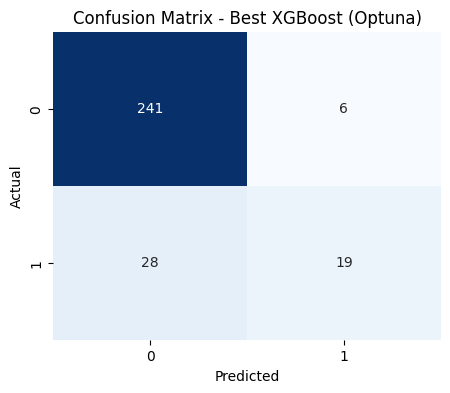

In [144]:
y_pred = best_xgb_optuna.predict(X_test)
y_proba = best_xgb_optuna.predict_proba(X_test)[:,1] if hasattr(best_xgb_optuna, "predict_proba") else None

print("=== Classification Report (Test set) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (TN, FP; FN, TP):")
print(cm)

if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC (test): {auc:.4f}")
else:
    print("Model has no predict_proba available.")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best XGBoost (Optuna)")
plt.show()

### ROC Curve

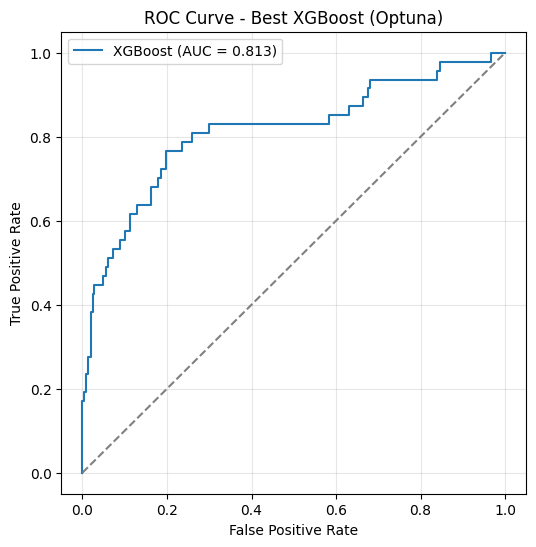

In [ ]:
if y_proba is not None:
    fpr, tpr, th = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Best XGBoost (Optuna)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

### Feature importance (XGBoost builtin)

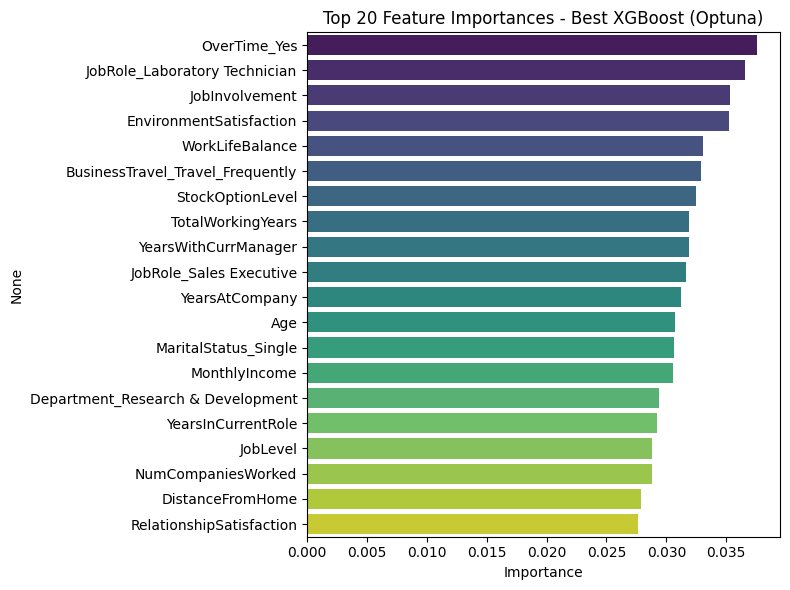

,feature,importance
0,OverTime_Yes,0.037610
1,JobRole_Laboratory Technician,0.036536
2,JobInvolvement,0.035304
3,EnvironmentSatisfaction,0.035221
4,WorkLifeBalance,0.033083
5,BusinessTravel_Travel_Frequently,0.032921
6,StockOptionLevel,0.032444
7,TotalWorkingYears,0.031882
8,YearsWithCurrManager,0.031861
9,JobRole_Sales Executive,0.031599


In [145]:
feat_imp = pd.Series(best_xgb_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Top 20 Feature Importances - Best XGBoost (Optuna)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

display(feat_imp.reset_index().rename(columns={'index':'feature',0:'importance'}))

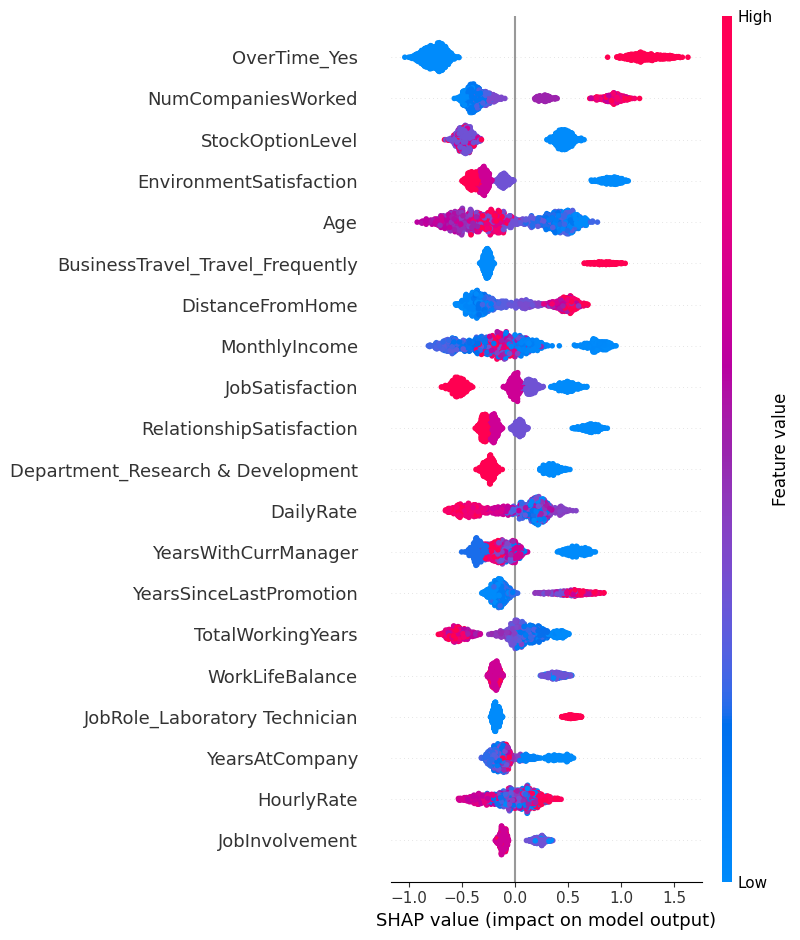

In [147]:
import shap
explainer = shap.TreeExplainer(best_xgb_optuna)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0])

In [78]:
import joblib
joblib.dump(best_xgb_optuna, "best_xgb_optuna.joblib")
print("Saved best_xgb_optuna.joblib")

Saved best_xgb_optuna.joblib


## Stacking Ensemble (Logistic + RF + XGBoost)

Stacking CV F1 scores: [0.574 0.387 0.505 0.481 0.438]
Stacking CV F1 mean: 0.477

=== Stacking Classifier - Test set ===
              precision    recall  f1-score   support

       False     0.9112    0.7895    0.8460       247
        True     0.3500    0.5957    0.4409        47

    accuracy                         0.7585       294
   macro avg     0.6306    0.6926    0.6435       294
weighted avg     0.8215    0.7585    0.7812       294

Confusion Matrix:
 [[195  52]
 [ 19  28]]
ROC AUC (stacking): 0.7851


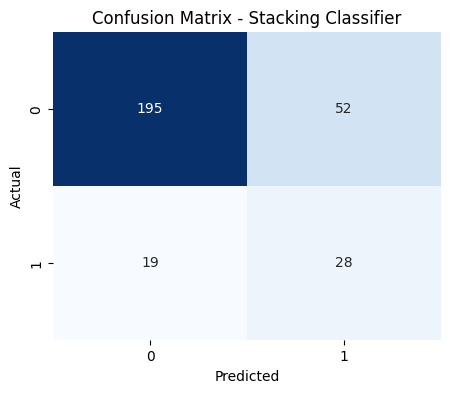

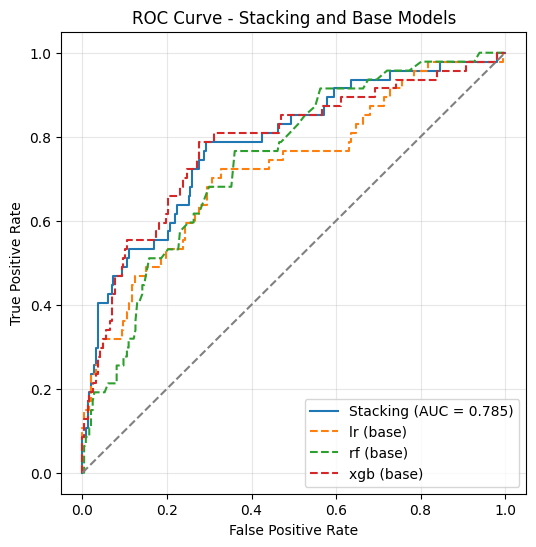


Stacking test metrics: {'accuracy': 0.7585034013605442, 'precision': 0.35, 'recall': 0.5957446808510638, 'f1': 0.4409448818897638, 'roc_auc': 0.7850805409596003}

Best XGBoost (Optuna) test metrics: {'accuracy': 0.8843537414965986, 'precision': 0.76, 'recall': 0.40425531914893614, 'f1': 0.5277777777777778, 'roc_auc': 0.8133344818675166}


In [ ]:
# ===== Stacking Ensemble: Logistic + RandomForest + XGBoost (with SMOTE in pipelines) =====
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# --- 1) Create base pipelines with SMOTE + classifier
smote = SMOTE(random_state=42)

# Logistic pipeline
pipe_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# RandomForest pipeline
pipe_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))
])

# XGBoost pipeline
try:
    xgb_params = study.best_params.copy()

  xgb_est = XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
except Exception:
    # fallback parameters
    xgb_est = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8,
                            colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42)

pipe_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb_est)
])

# --- 2) Build StackingClassifier
estimators = [
    ('lr', pipe_lr),
    ('rf', pipe_rf),
    ('xgb', pipe_xgb)
]

final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# --- 3) Cross-val evaluation on training set (to get expected CV F1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stack_clf, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print("Stacking CV F1 scores:", np.round(cv_scores, 3))
print("Stacking CV F1 mean:", np.round(cv_scores.mean(), 3))

# --- 4) Fit on full training set and evaluate on test set
stack_clf.fit(X_train, y_train)

y_pred_stack = stack_clf.predict(X_test)
y_proba_stack = stack_clf.predict_proba(X_test)[:,1] if hasattr(stack_clf, "predict_proba") else None

print("\n=== Stacking Classifier - Test set ===")
print(classification_report(y_test, y_pred_stack, digits=4))
cm_stack = confusion_matrix(y_test, y_pred_stack)
print("Confusion Matrix:\n", cm_stack)
if y_proba_stack is not None:
    auc_score = roc_auc_score(y_test, y_proba_stack)
    print(f"ROC AUC (stacking): {auc_score:.4f}")

# --- 5) Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()

# --- 6) Plot ROC curve 
if y_proba_stack is not None:
    fpr, tpr, th = roc_curve(y_test, y_proba_stack)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'Stacking (AUC = {auc(fpr,tpr):.3f})')
    # also plot individual model ROC curves for comparison 
    try:
        # get individual base model probs 
        for name in ['lr','rf','xgb']:
            est = stack_clf.named_estimators_[name]
            # For estimators inside pipelines, the pipeline returns predict_proba if final step supports it
            if hasattr(est, 'predict_proba'):
                y_p = est.predict_proba(X_test)[:,1]
                fpr_i, tpr_i, _ = roc_curve(y_test, y_p)
                plt.plot(fpr_i, tpr_i, linestyle='--', label=f'{name} (base)')
    except Exception:
        pass
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Stacking and Base Models')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# --- 7) Compare stacking result with best_xgb_optuna and print short summary
try:
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    stack_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_stack),
        'precision': precision_score(y_test, y_pred_stack, zero_division=0),
        'recall': recall_score(y_test, y_pred_stack, zero_division=0),
        'f1': f1_score(y_test, y_pred_stack, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_stack) if y_proba_stack is not None else None
    }
    print("\nStacking test metrics:", stack_metrics)
    # compare to best_xgb_optuna if available
    if 'best_xgb_optuna' in globals():
        y_pred_xgb = best_xgb_optuna.predict(X_test)
        y_proba_xgb = best_xgb_optuna.predict_proba(X_test)[:,1] if hasattr(best_xgb_optuna, "predict_proba") else None
        xgb_metrics = {
            'accuracy': accuracy_score(y_test, y_pred_xgb),
            'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
            'recall': recall_score(y_test, y_pred_xgb, zero_division=0),
            'f1': f1_score(y_test, y_pred_xgb, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_proba_xgb) if y_proba_xgb is not None else None
        }
        print("\nBest XGBoost (Optuna) test metrics:", xgb_metrics)
except Exception as e:
    print("Comparison failed:", e)


### Stacking Ensemble is not better than XGBoost

## Visualization & Packaging

In [91]:
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
# t-test example
yes = df[df.Attrition=='Yes']['MonthlyIncome']
no  = df[df.Attrition=='No']['MonthlyIncome']
ttest_ind(yes, no)


TtestResult(statistic=np.float64(-6.203935765608938), pvalue=np.float64(7.147363985353811e-10), df=np.float64(1468.0))

In [92]:
df['tenure_cat'] = pd.cut(df['YearsAtCompany'], bins=[-1,2,6,100], labels=['short','medium','long'])
df['salary_band'] = pd.qcut(df['MonthlyIncome'], q=3, labels=['low','med','high'])

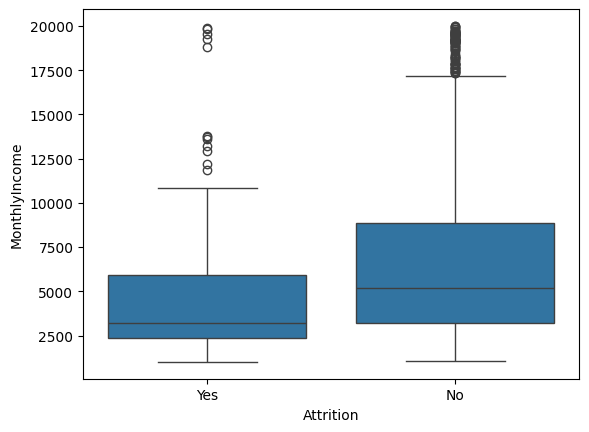

In [94]:
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.show()

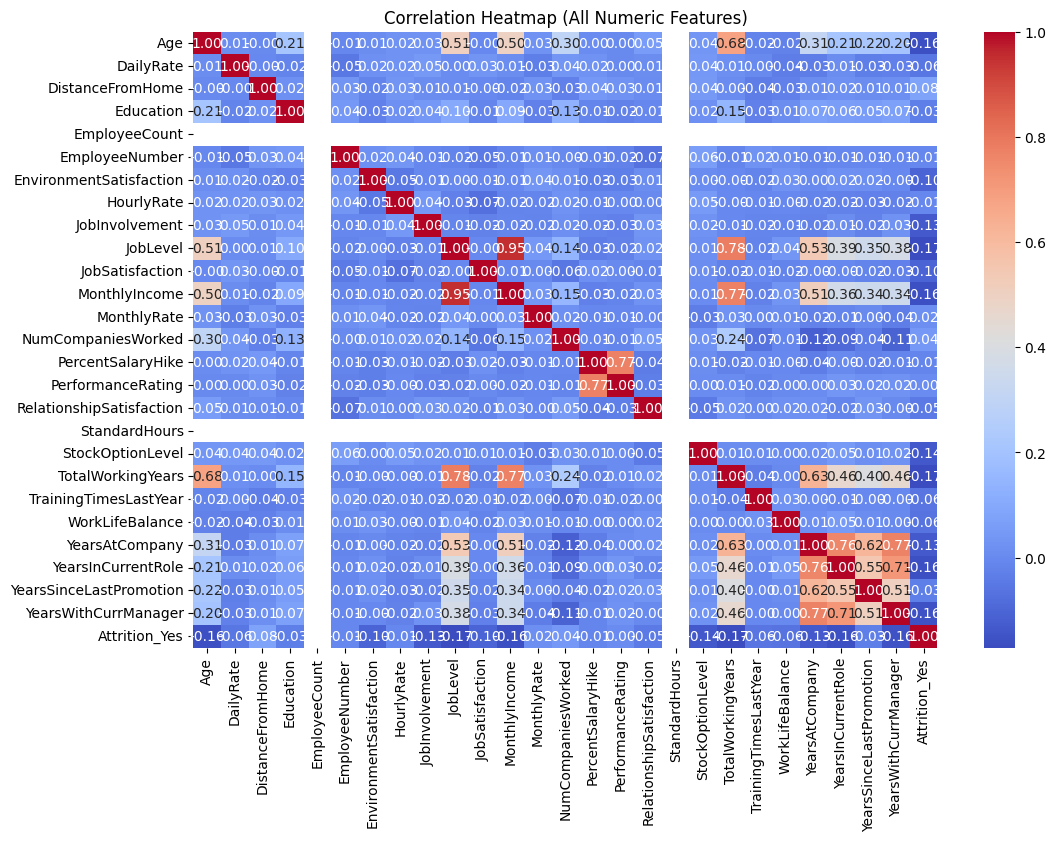

In [96]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (All Numeric Features)")
plt.show()

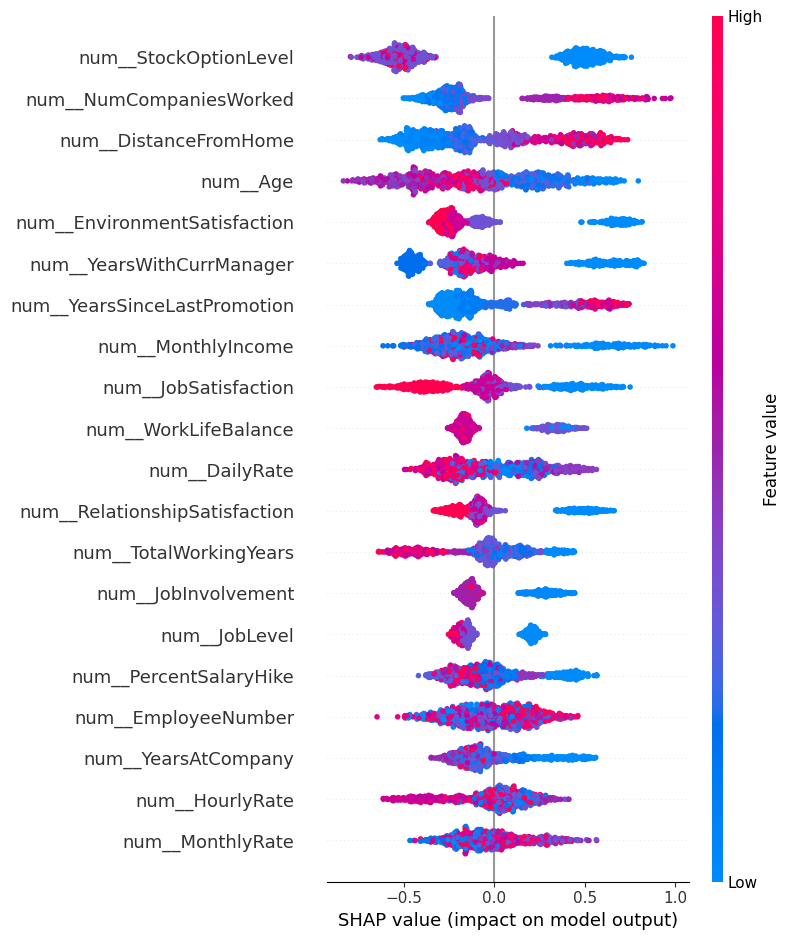

In [ ]:
import shap
X_shap = X_train.sample(n=min(1000, X_train.shape[0]), random_state=42)

explainer = shap.Explainer(pipeline.named_steps['model'])   
X_preprocessed = pipeline.named_steps['preproc'].transform(X_shap)

explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_preprocessed)

# Plot (summary)
shap.summary_plot(shap_values, features=X_preprocessed, feature_names=pipeline.named_steps['preproc'].get_feature_names_out())

## FINAL pipeline & Save

In [174]:
categorical_features = [col for col in categorical_features if col in X_train.columns]
numeric_features = [col for col in numeric_features if col in X_train.columns]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'      
)
print("Preprocessor created with %d numeric and %d categorical transformers." % (len(numeric_features), len(categorical_features)))

Preprocessor created with 26 numeric and 0 categorical transformers.


In [175]:
# Ensure best_xgb_optuna exists: instantiate using Optuna best params and fit
try:
    best_params = study.best_params
    print("Using Optuna best params:", best_params)
    best_xgb_optuna = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
except Exception as e:
    print("Optuna study not found or best_params unavailable. Falling back to manual tuned params.")
    # fallback params (عدلهم لو عندك قيم مختلفة)
    best_xgb_optuna = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight=1,
        use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1
    )

# best_xgb_optuna.fit(X_train, y_train)
print("best_xgb_optuna ready.")


Using Optuna best params: {'n_estimators': 745, 'max_depth': 7, 'learning_rate': 0.09483399772916264, 'subsample': 0.5605929712000844, 'colsample_bytree': 0.6168474772051658, 'gamma': 2.385392818346701, 'min_child_weight': 9}
best_xgb_optuna ready.


In [176]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('preproc', preprocessor), ('model', best_xgb_optuna)])
joblib.dump(pipeline, 'best_pipeline_attrition.pkl')

# Evaluate quickly
print("Classification report (pipeline):")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

joblib.dump(pipeline, 'best_pipeline_attrition.pkl')
print("Saved pipeline to best_pipeline_attrition.pkl")

Classification report (pipeline):
              precision    recall  f1-score   support

           0     0.8959    0.9757    0.9341       247
           1     0.7600    0.4043    0.5278        47

    accuracy                         0.8844       294
   macro avg     0.8280    0.6900    0.7309       294
weighted avg     0.8742    0.8844    0.8692       294

Confusion matrix:
 [[241   6]
 [ 28  19]]
Saved pipeline to best_pipeline_attrition.pkl


In [179]:
# Inference test on raw sample 
# probabilities if employees will leave or not (Attrition=1 --> he will leave)
pipeline.fit(X_train, y_train)
sample_raw = df.drop(columns=['Attrition']) .iloc[0:3] 
print("Raw sample shape:", sample_raw.shape)
probs = pipeline.predict_proba(sample_raw)[:,1]
preds = pipeline.predict(sample_raw)
sample_raw['Predicted_Prob'] = probs
sample_raw['Predicted_Label'] = preds
sample_raw[['Predicted_Prob','Predicted_Label']]

Raw sample shape: (3, 34)


,Predicted_Prob,Predicted_Label
0,0.286422,0
1,0.026596,0
2,0.294120,0
